# Исследование пользовательского поведения в мобильном приложении
Необходимо провести исследование поведения пользователей мобильного приложения для стартапа, который продаёт продукты питания. Нужно выяснить, как пользователи доходят до покупки, какая доля доходит, на каких шагах застревают. Нужно провести анализ А/А/В-тестирования, чтобы понять повлияло ли изменение шрифта на пользователей, если да, то как. 

**Цель:** исследование поведения пользователей мобильного приложения

**Ход исследования:**  
1. Загрузка и обзор данных
2. Предобработка данных
3. Изучение данных (количество событий, пользователей, рассматриваемый временной период)
4. Исследование воронки событий (как пользователи доходят до покупки, сколько пользователей доходит до покупки)
5. Исследование результатов проведения А/А/В-теста
6. Написание общего вывода исследования

In [39]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from plotly import graph_objects as go
import math as mth

## Загрузка и обзор данных
Откроем файл с данными и изучите общую информацию, применив методы info(), describe(), также проверим данные на дубликаты.

In [40]:
# загрузим данных
logs_exp = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [41]:
# изучим данные
def analysis(df):
    display(df.head(), df.info(), df.describe(), df.duplicated().sum())

analysis(logs_exp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


None

,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


413

In [42]:
# проверим уникальные значения каждого столбца (категориальных) для проверки на неявные дубликаты
for i in logs_exp.columns:
    display(logs_exp[i].value_counts().to_frame())
    print(logs_exp[i].unique())
    print()

,EventName
MainScreenAppear,119205
OffersScreenAppear,46825
CartScreenAppear,42731
PaymentScreenSuccessful,34313
Tutorial,1052


['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']



,DeviceIDHash
6304868067479728361,2308
197027893265565660,2003
4623191541214045580,1771
6932517045703054087,1448
1754140665440434215,1222
...,...
8188293597840107588,1
1616856457908967248,1
732356052255400077,1
6671109879025379318,1


[4575588528974610257 7416695313311560658 3518123091307005509 ...
 6660805781687343085 7823752606740475984 3454683894921357834]



,EventTimestamp
1564670435,9
1564935799,9
1564911846,8
1565176721,8
1565191469,8
...,...
1564980679,1
1564724680,1
1564732876,1
1564673489,1


[1564029816 1564053102 1564054127 ... 1565212483 1565212498 1565212517]



,ExpId
248,85747
246,80304
247,78075


[246 248 247]



**Вывод:**

Датасет содержит 244 126 строк и 4 столбца. Столбцы содержат следующую информацию:
- EventName — название события
- DeviceIDHash — уникальный идентификатор пользователя
- EventTimestamp — время события
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная

Можем сделать следующие выводы, исследовав данные:
- в данных нет пропусков
- колонка EventTimestamp (время события) имеет неверный тип данных
- названия колонок не имеют нижний регистр, можно их преобразовать для более удобного использования
- в данных есть 413 дублированных строк
- неявных дубликатов в данных нет

## Предобработка данных
Исходя из выводов предыдущего раздела изменим названия столбцов, изменим тип данных столбца EventTimestamp и удалим дубликаты.  
Также создадим столбцы, содержащие только дату и только время события.

In [43]:
# изменим названия столбцов 
# logs_exp.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']
logs_exp = logs_exp.rename(columns={'EventName': 'event_name',
                                    'DeviceIDHash': 'device_id_hash',
                                    'EventTimestamp': 'event_timestamp',
                                    'ExpId': 'exp_id'})

In [44]:
# преобразуем тип данных 
logs_exp.event_timestamp = pd.to_datetime(logs_exp.event_timestamp, unit='s')

In [45]:
# избавимся от дубликатов
logs_exp = logs_exp.drop_duplicates().reset_index(drop=True)
logs_exp

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246


In [46]:
# создадим столбец date, который содержит дату события
logs_exp['date'] = logs_exp.event_timestamp.astype('datetime64[D]')

# создадим столбец time, который содержит время события
logs_exp['time'] = logs_exp.event_timestamp.dt.time

In [47]:
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   date             243713 non-null  datetime64[ns]
 5   time             243713 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 11.2+ MB


**Вывод:**  
в ходе предобработки были изменены названия столбцов, тип данных столбца EventTimestamp и удалены дубликаты.
Также были созданы дополнительные столбцы, содержащие дату и время события.

## Изучение и проверка данных
### Количество событий, пользователей в логе

In [48]:
# количество событий в логе (одна запись - одно событие)
print(f'Количество событий в логе (одна запись - одно событие): {logs_exp.shape[0]}')

# количество пользователей в логе
print(f'Количество уникальных пользователей в логе: {logs_exp.device_id_hash.nunique()}')

# количество событий на одного пользователя
print(f'Количество событий на одного пользователя (по среднему значению): {logs_exp.shape[0] / logs_exp.device_id_hash.nunique():.0f}')

Количество событий в логе (одна запись - одно событие): 243713
Количество уникальных пользователей в логе: 7551
Количество событий на одного пользователя (по среднему значению): 32


Максимальное количество событий для одного пользователя равно 2307, а минимальное — 1. Если мы будем считать среднее количество событий на одного пользователя по среднему значению, то получится не совсем верное значение. По гистограммме также видно, что несмотря на высокие значения, доходящие до 2 тыс., основное количество расположено в диапозоне до 100, поэтому найдем среднее количество событий на одного пользователя по медиане.  

Среднее количество событий на одного пользователя (по медиане): 20

20

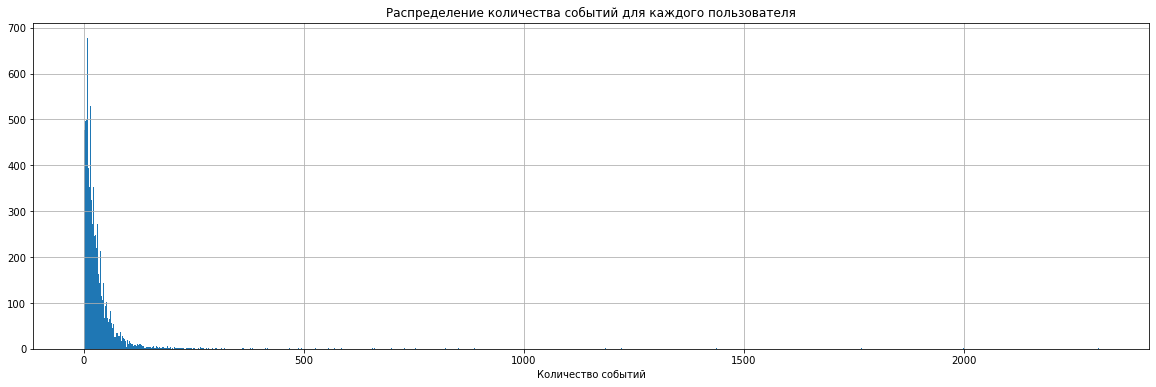

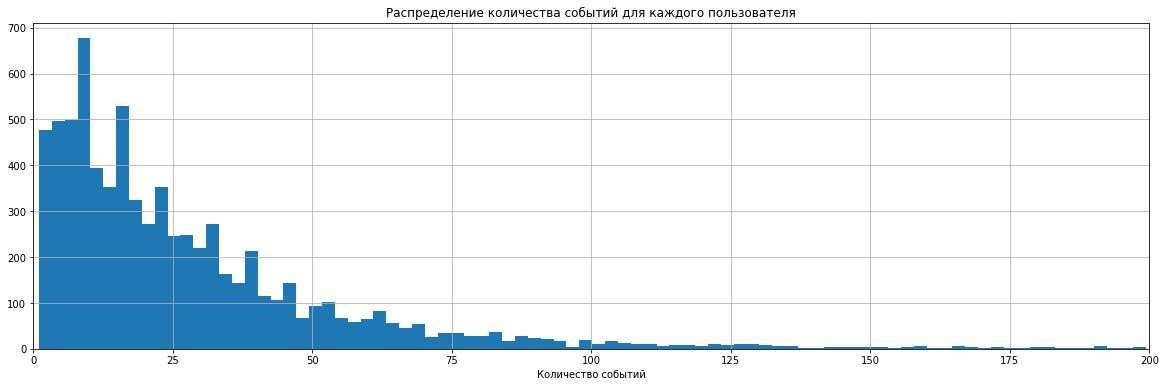

In [49]:
plt.figure(figsize=(20, 6))
logs_exp.device_id_hash.value_counts().hist(bins=1000)
plt.title('Распределение количества событий для каждого пользователя')
plt.xlabel('Количество событий');

plt.figure(figsize=(20, 6))
logs_exp.device_id_hash.value_counts().hist(bins=1000)
plt.title('Распределение количества событий для каждого пользователя')
plt.xlabel('Количество событий')
plt.xlim(left=0, right=200);

logs_exp.device_id_hash.value_counts().median().astype(int)

### Изучение временного периода
У нас есть данные за период с 25 июля до 7 августа 2019 года. По гистограмме видно, что большая часть данных с 1 августа, до этого периода данных очень мало, поэтому отбросим данные за период с 25 июля до 1 августа и проверим, много ли событий мы упустим.

In [50]:
# минимальная дата
print(f'Минимальная дата: {logs_exp.date.min()}')

# максимальная дата
print(f'Максимальная дата: {logs_exp.date.max()}')

Минимальная дата: 2019-07-25 00:00:00
Максимальная дата: 2019-08-07 00:00:00


In [51]:
logs_exp.date.value_counts().to_frame()

,date
2019-08-01,36141
2019-08-05,36058
2019-08-06,35788
2019-08-02,35554
2019-08-03,33282
2019-08-04,32968
2019-08-07,31096
2019-07-31,2030
2019-07-30,412
2019-07-29,184


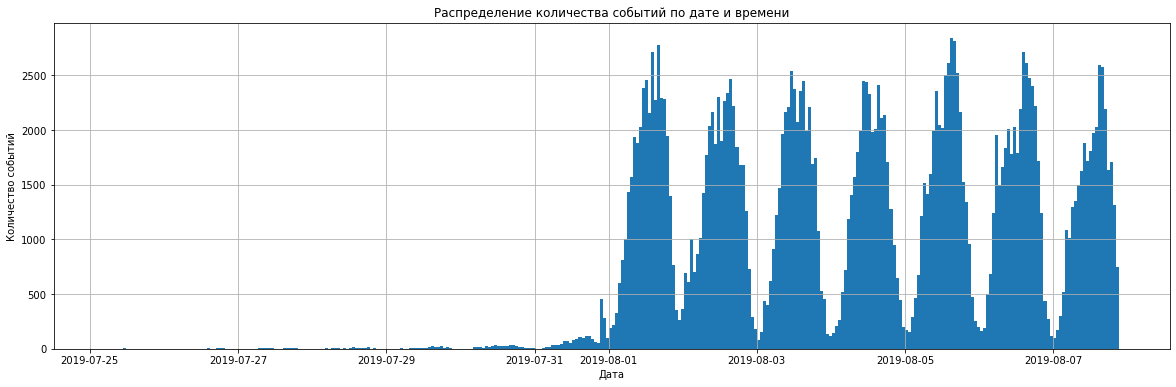

In [52]:
plt.figure(figsize=(20, 6))
logs_exp.event_timestamp.hist(bins=24*14)
plt.title('Распределение количества событий по дате и времени')
plt.ylabel('Количество событий')
plt.xlabel('Дата');

### Изменения после отброса неполных данных

In [53]:
logs_exp_new = logs_exp.query('date >= "2019-08-01T00:00:00.000000000"')

In [54]:
# количество событий в логе (одна запись - одно событие)
print(f'Количество событий в логе (одна запись - одно событие): {logs_exp_new.shape[0]}')
print(f'Отбросили {-(len(logs_exp_new) / len(logs_exp) - 1):.2%} от всех событий')
print()

# количество пользователей в логе
print(f'Количество уникальных пользователей в логе: {logs_exp_new.device_id_hash.nunique()}')
print(f'Отбросили {-(logs_exp_new.device_id_hash.nunique() / logs_exp.device_id_hash.nunique() - 1):.2%} от всех уникальных пользователей')
print()

# количество событий на одного пользователя
print(f'Количество событий на одного пользователя (по среднему значению): {logs_exp_new.shape[0] / logs_exp_new.device_id_hash.nunique():.0f}')
print(f'Количество событий на одного пользователя (по медиане): {logs_exp_new.device_id_hash.value_counts().median().astype(int)}')

Количество событий в логе (одна запись - одно событие): 240887
Отбросили 1.16% от всех событий

Количество уникальных пользователей в логе: 7534
Отбросили 0.23% от всех уникальных пользователей

Количество событий на одного пользователя (по среднему значению): 32
Количество событий на одного пользователя (по медиане): 19


Отбросив старые данные, мы отбросили 1.16% событий и 0.23% пользователей, что не очень много. Среднее значение событий на одного пользователя по среднему значению не изменилось и равно 32 события, по медиане стало 19 событий (предпочтительнее).  
После отброса данных остались пользователи всех трех экспериментальных групп, более того группы не сильно отличаются друг от друга по размеру.

device_id_hash        
                count nunique
exp_id                       
246             79302    2484
247             77022    2513
248             84563    2537

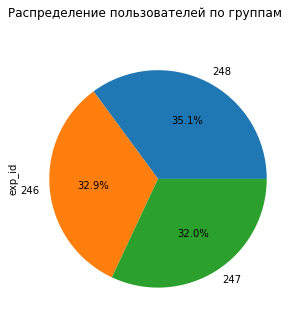

In [55]:
display(logs_exp_new.groupby('exp_id').agg({'device_id_hash': ['count', 'nunique']}))

plt.figure(figsize=(15, 5))
logs_exp_new.exp_id.value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.suptitle('Распределение пользователей по группам');

### Вывод

- в логе 243 713 событий
- в логе 7 551 уникальный пользователь  
- на одного пользователя приходится 20 событий
- в датасете представлены события за период с 25.07.2019 по 07.08.2019, но данные до 1 августа неполные, поэтому в исследовании рассматривались данные с 1 августа

Выводы после отброса данных:
- в логе 240 887 событий (отбросили 1.16% от всех событий)
- в логе 7 534 уникальный пользователь (отбросили 0.23% от всех уникальных пользователей)
- на одного пользователя приходится 19 событий

После отброса данных остались пользователи всех трех экспериментальных групп, более того группы не сильно отличаются друг от друга по размеру.

## Изучение воронки событий
### Распределение событий в логе
Рассмотрим, какие события есть в логе и как они распределены.  
Есть события: 
- MainScreenAppear — главный экран
- OffersScreenAppear — экран предложения
- CartScreenAppear — экран корзины
- PaymentScreenSuccessful — экран успешного платежа
- Tutorial	— руководство

Чаще всего среди них встречается событие MainScreenAppear, его доля от всего количества событий — 48.7%.

,event_name
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


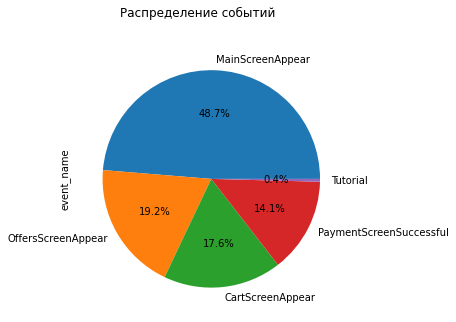

In [56]:
display(logs_exp_new.event_name.value_counts().to_frame())

plt.figure(figsize=(15, 5))
plt.suptitle('Распределение событий')
logs_exp_new.event_name.value_counts().plot(kind='pie', autopct='%1.1f%%', subplots=True);

### Количество пользователей для каждого события
Рассмотрим теперь сколько пользователей совершали каждое из этих событий и какая доля тех пользователей, которые хоть раз совершали событие.  
Последовательность событий по количеству уникальных пользователей такая же, как и по количеству событий. То есть из событий - MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful можно выстроить воронку. Событие Tutorial скорее всего не входит в воронку, так как не появляется после этапа успешной оплаты заказа.

In [57]:
df1 = (logs_exp_new.pivot_table(index='event_name', values='device_id_hash', aggfunc=['nunique'])
      .set_axis(['device_id_hash'], axis=1).sort_values(by='device_id_hash', ascending=False))
df1['share'] = (df1['device_id_hash'] / 
               logs_exp_new.device_id_hash.nunique()).apply(lambda x: f'{x:.1%}')
df1

,device_id_hash,share
event_name,,
MainScreenAppear,7419,98.5%
OffersScreenAppear,4593,61.0%
CartScreenAppear,3734,49.6%
PaymentScreenSuccessful,3539,47.0%
Tutorial,840,11.1%


### Воронка событий
Для того, чтобы понять, какая доля пользователей переходит на следующий шаг (от числа пользователей на предыдущем), построим воронку. 

Получаем,что:  
- Количество пользователей на втором шаге составляет **62%** пользователей от предыдущего.   
- Количество пользователей на третьем шаге составляет **81%** пользователей от предыдущего.  
- Количество пользователей на четвертом шаге составляет **95%** пользователей от предыдущего.  

То есть самое большое количество пользователей теряется при переходе с шага главного экрана (MainScreenAppear) на шаг с экраном предложения (OffersScreenAppear).  
Больше всего сохраняется пользователей при переходе с шага с экраном корзины (CartScreenAppear) на шаг с экраном успешного платежа (PaymentScreenSuccessful).

In [58]:
event_name = df1.index[:-1]
df1['conversion'] = (df1['device_id_hash'] / df1['device_id_hash']
                     .shift(1, fill_value=df1['device_id_hash'][0])).apply(lambda x: f'{x:.1%}')
df1

,device_id_hash,share,conversion
event_name,,,
MainScreenAppear,7419,98.5%,100.0%
OffersScreenAppear,4593,61.0%,61.9%
CartScreenAppear,3734,49.6%,81.3%
PaymentScreenSuccessful,3539,47.0%,94.8%
Tutorial,840,11.1%,23.7%


In [59]:
logs_exp_new

,event_name,device_id_hash,event_timestamp,exp_id,date,time
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,00:07:28
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,00:08:00
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,00:08:55
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,00:08:58
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,00:08:59
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,21:12:25
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,21:13:59
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,21:14:43
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,21:14:58


In [60]:
fig = go.Figure(go.Funnel(
    y = event_name,
    x = df1.device_id_hash[:-1],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal"],
    "line": {"width": [4, 2, 2, 1, 1], "color": ["wheat", "wheat", "wheat", "wheat"]}},
    connector = {"line": {"color": "wheat", "dash": "dot", "width": 3}})
    )

fig.update_layout(
    title="Воронка событий",
    yaxis_title="Название события воронки",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"))

fig.show()

Теперь найдем количество пользователей, которые проходят от первого шага до последнего, то есть проходят все шаги последовательно и в итоге доходят до оплаты. Для этого построим сводную таблицу, при этом будем рассматривать только события, которые мы включаем в воронку (исключим события Tutorial).  
Затем рассмотрим какое количество пользователей проходило все шаги воронки последовательно и дошло до конца. Для этого будем учитывать время перехода на каждый из шагов.  
Получили, что от всего количества пользователей до оплаты доходят только 454 или 6%. То есть большая часть пользователей не проходят все шаги, а могут начать путь с любого другого шага, поскольку в предыдущем пункте мы видели, что до оплаты всего доходят 3539 пользователей.

In [61]:
logs_exp_new = logs_exp_new.query('event_name != "Tutorial"')

# сводная таблица для шагов
df2 = logs_exp_new.pivot_table(index='device_id_hash', 
                               columns='event_name', 
                               values='event_timestamp', 
                               aggfunc='min')

# количество пользователей, переходящих на следующий шаг
st1 = ~df2['MainScreenAppear'].isna()
st2 = st1 & (df2['OffersScreenAppear'] > df2['MainScreenAppear'])
st3 = st2 & (df2['CartScreenAppear'] > df2['OffersScreenAppear'])
st4 = st3 & (df2['PaymentScreenSuccessful'] > df2['CartScreenAppear'])

# выведем таблицу
df3 = pd.DataFrame(data={'event_name': event_name, 
                   'device_id_hash': [st1.sum(), st2.sum(), st3.sum(), st4.sum()]}).set_index('event_name')
df3['share'] = (df3['device_id_hash'] / st1.sum()).apply(lambda x: f'{x:.2%}')
df3

,device_id_hash,share
event_name,,
MainScreenAppear,7419,100.00%
OffersScreenAppear,4201,56.62%
CartScreenAppear,1767,23.82%
PaymentScreenSuccessful,454,6.12%


In [77]:
fig = go.Figure()

for group, name in ([df1[:-1].device_id_hash, 'Уникальные пользователи на каждом шагу'], 
                    [df3.device_id_hash, 'Уникальные пользователи, проходящие шаги последовательно от первоого до последнего']): 
    fig.add_trace(go.Funnel(
        name = name,
        orientation = "h",
        y = df1.index,
        x = group,
        textposition = "inside",
        textinfo = "value+percent previous"))
    
fig.update_layout(
    title="Воронка событий",
    yaxis_title="Название события воронки",
    legend_title="Группа",
    legend_orientation="h",
    font=dict(
        family="Courier New, monospace",
        size=12.5,
        color="RebeccaPurple"))

fig.show()

### Вывод

В логах есть следующие события (в скобках указана доля события от всех событий):
- MainScreenAppear — главный экран (48.7%)
- OffersScreenAppear — экран предложения (19.2%)
- CartScreenAppear — экран корзины (17.6%)
- PaymentScreenSuccessful — экран успешного платежа (14.1%)
- Tutorial — руководство (0.4%)

События можно выстроить в воронку с следующей последовательность: 
1. MainScreenAppear
2. OffersScreenAppear
3. CartScreenAppear
4. PaymentScreenSuccessful 

Событие Tutorial скорее всего не входит в воронку, так как не появляется после этапа успешной оплаты заказа, поэтому из дальнейшего анализа данное событие было удалено.  

По количеству пользователей и доле от всех уникальных пользователей, которые хоть раз совершали событие, также выстраиваются в воронку:
- MainScreenAppear (7419 пользователей,	98.47% от всех уникальных пользователей)
- OffersScreenAppear (4593 пользователей, 60.96% от всех уникальных пользователей)
- CartScreenAppear (3734 пользователей,	49.56% от всех уникальных пользователей)
- PaymentScreenSuccessful (3539 пользователей,	46.97% от всех уникальных пользователей)
- Tutorial (840 пользователей,	11.15% от всех уникальных пользователей)

После построения воронки получили следующие выводы:
- Количество пользователей на втором шаге составляет **62%** пользователей от предыдущего.   
- Количество пользователей на третьем шаге составляет **81%** пользователей от предыдущего.  
- Количество пользователей на четвертом шаге составляет **95%** пользователей от предыдущего.  

То есть самое большое количество пользователей теряется при переходе с шага главного экрана (MainScreenAppear) на шаг с экраном предложения (OffersScreenAppear).  
Больше всего сохраняется пользователей при переходе с шага с экраном корзины (CartScreenAppear) на шаг с экраном успешного платежа (PaymentScreenSuccessful).  

Последовательно от первого события до оплаты проходят только 454 или 6% от тех, кто был на первой событии.

## Изучение результатов эксперимента
### Проверка количества пользователей в группах

Как уже смотрели ранее, количество уникальных пользователей в каждой эксперементальной группе не сильно отличается друг от друга.

,exp_id,device_id_hash
0,246,2483
1,247,2512
2,248,2535
3,246+247,4995


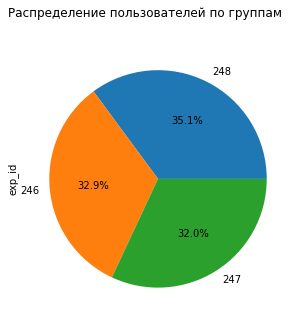

In [63]:
users = logs_exp_new.groupby('exp_id').agg({'device_id_hash':'nunique'}).reset_index()

plt.figure(figsize=(15, 5))
logs_exp_new.exp_id.value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.suptitle('Распределение пользователей по группам');
users.loc[len(users.index )] = ['246+247', users.query('exp_id in (246, 247)').device_id_hash.sum()]
display(users)

Также выполним проверку того, нет ли в экперементальных групах повторяющихся пользователей. Для этого создадим сводную таблицу, в которой для каждого уникального пользователя посчитаем количество групп, в которые он попал, а затем выведем тех пользователей, которые попали больше, чем в одну группу.  
Получили, что таких пользователей нет, то есть каждый уникальный пользователь попал только в одну группу.

In [64]:
logs_exp_new.pivot_table(index='device_id_hash', values='exp_id', aggfunc='nunique').query('exp_id > 1')

,exp_id
device_id_hash,


### Проверка гипотез
Теперь проверим с помощью статистических критериев, есть ли разница между группами. Для автоматизации этого создадим функцию, так как необходимо проверить разницу между всеми 3 группами. Функция будет создавать таблицу для расчетов, строить воронку событий по двум рассматриваемым группам, а также проверять есть ли статистическая разница между отношением уникальных пользователей, совершивших событие к количеству пользователей в группе.  

Будет проверяться гипотеза о равенстве долей, проверяться она будет для каждого события. Сформулируем нулевую и альтернативную гипотезы.  

**Н0:** Для рассматриваемых групп доли уникальных пользователей, совершивших событие к количеству пользователей в группе равны.   
**Н1:** Для рассматриваемых групп доли уникальных пользователей, совершивших событие к количеству пользователей в группе не равны.  

Для ее проверки будем использовать z-тест. Выберем уровень значимости равный alpha = 0.05.

In [66]:
def data(group1, group2):
    if group1 == '246+247' or group2 == '246+247':
        data = (logs_exp_new.pivot_table(index='event_name', 
                         columns='exp_id', 
                         values='device_id_hash', 
                         aggfunc='nunique').reset_index())
        data['246+247'] = data[246] + data[247]
    else:
    # составляем сводную таблицу с количеством пользователей по событиям и группам    
        data = (logs_exp_new.query('exp_id in (@group1, @group2)')
            .pivot_table(index='event_name', 
                         columns='exp_id', 
                         values='device_id_hash', 
                         aggfunc='nunique').reset_index())
    data = data.sort_values(by=data.columns[1], ascending=False).reset_index(drop=True)
    return data

def stat_difference(group1, group2, alpha, data):
    # пропорция успехов в комбинированном датасете:
    data['combined'] = (data[group1] + data[group2]) / (int(users[users.exp_id == group1].device_id_hash) 
                                                        + int(users[users.exp_id == group2].device_id_hash))
    
    # рассчитываем долю от для каждого шага 
    for group in [group1, group2]:
         data['p_' + str(group)] = data[group].apply(lambda x: x / users[users.exp_id == group].device_id_hash)
    
    # разница пропорций в датасетах
    data['difference'] = data['p_' + str(group1)] - data['p_' + str(group2)]
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    data['z_value'] = data['difference'] / (data['combined'] * (1 - data['combined']) 
                                            * (1/int(users[users.exp_id == group1].device_id_hash)
                                               + 1/int(users[users.exp_id == group2].device_id_hash)))**0.5

    data['p_value'] = (1 - stats.norm(0, 1).cdf(abs(data['z_value']))) * 2
    display(data)
    print(f'Для групп {group1} и {group2} с заданным уровнем значимости {alpha:.0%}')
    print()
    for i in range(len(data)):
        print(f'{event_name[i]}')
        print(f'p-значение: {data.p_value[i]:.4f}')
        if data['p_value'][i] < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 
        print()

def funnel(group1, group2, data):        
    fig = go.Figure()

    for group in [group1, group2]: 
        fig.add_trace(go.Funnel(
            name = group,
            orientation = "h",
            y = event_name,
            x = data[group],
            textposition = "inside",
            textinfo = "value+percent previous"))
    
    fig.update_layout(
    title="Воронка событий",
    yaxis_title="Название события воронки",
    legend_title="Группа",
    legend_orientation="h",
    font=dict(
        family="Courier New, monospace",
        size=12.5,
        color="RebeccaPurple"))

    fig.show()

В первую очередь проведем А/А тест для контрольных групп 246 и 247, чтобы проверить корректность всех механизмов и расчётов.  
По воронке видно, что конверсия перехода к следующему событию для обеих групп различается на 1-2%.  
Проведя статистический тест, получили, что для всех событий не получилось отвергнуть нулевую гипотезу, поэтому оснований считать доли разными нет. Поэтому можно сказать, что разбиение на группы работает корректно.

In [67]:
stat_difference(246, 247, 0.05, data(246, 247))
funnel(246, 247, data(246, 247))

exp_id,event_name,246,247,combined,p_246,p_247,difference,z_value,p_value
0,MainScreenAppear,2450,2476,0.986186,0.986710,0.985669,0.001041,0.315120,0.752670
1,OffersScreenAppear,1542,1520,0.613013,0.621023,0.605096,0.015927,1.155561,0.247861
2,CartScreenAppear,1266,1238,0.501301,0.509867,0.492834,0.017033,1.203775,0.228676
3,PaymentScreenSuccessful,1200,1158,0.472072,0.483286,0.460987,0.022299,1.578433,0.114466


Для групп 246 и 247 с заданным уровнем значимости 5%

MainScreenAppear
p-значение: 0.7527
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение: 0.2479
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение: 0.2287
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение: 0.1145
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Теперь проверим контрольную 246 группу и эксперементальную 248 группу. Разница в конверсии составляет также 1-2%.  
После проверки гипотез значимых различий между событиями двух групп также не выявлено.

In [68]:
stat_difference(246, 248, 0.05, data(246, 248))
funnel(246, 248, data(246, 248))

exp_id,event_name,246,248,combined,p_246,p_248,difference,z_value,p_value
0,MainScreenAppear,2450,2493,0.985054,0.986710,0.983432,0.003278,0.956714,0.338711
1,OffersScreenAppear,1542,1531,0.612395,0.621023,0.603945,0.017078,1.241490,0.214425
2,CartScreenAppear,1266,1230,0.497409,0.509867,0.485207,0.024660,1.746791,0.080674
3,PaymentScreenSuccessful,1200,1181,0.474492,0.483286,0.465878,0.017409,1.234732,0.216930


Для групп 246 и 248 с заданным уровнем значимости 5%

MainScreenAppear
p-значение: 0.3387
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение: 0.2144
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение: 0.0807
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение: 0.2169
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Теперь проверим контрольную 247 группу и эксперементальную 248 группу. Тут разница в конверсии тоже составляет 1-2%.  
После проверки гипотез значимых различий между событиями двух групп также не выявлено.

In [69]:
stat_difference(247, 248, 0.05, data(247, 248))
funnel(247, 248, data(247, 248))

exp_id,event_name,247,248,combined,p_247,p_248,difference,z_value,p_value
0,MainScreenAppear,2476,2493,0.984545,0.985669,0.983432,0.002237,0.644122,0.519496
1,OffersScreenAppear,1520,1531,0.604518,0.605096,0.603945,0.001151,0.083599,0.933375
2,CartScreenAppear,1238,1230,0.489003,0.492834,0.485207,0.007627,0.541986,0.587828
3,PaymentScreenSuccessful,1158,1181,0.463444,0.460987,0.465878,-0.004890,-0.348357,0.727572


Для групп 247 и 248 с заданным уровнем значимости 5%

MainScreenAppear
p-значение: 0.5195
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение: 0.9334
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение: 0.5878
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение: 0.7276
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Теперь сравним объединенную группу, состоящую из контрольных 246 и 247 групп и эксперементальную 248 группу. По воронке событий видно, что разница в конверсии составляет также 1-2%.  
Проведя статистический тест, получили, что для всех событий не получилось отвергнуть нулевую гипотезу, поэтому оснований считать доли разными нет.

In [70]:
stat_difference('246+247', 248, 0.05, data('246+247', 248))
funnel('246+247', 248, data('246+247', 248))

exp_id,event_name,246,247,248,246+247,combined,p_246+247,p_248,difference,z_value,p_value
0,MainScreenAppear,2450,2476,2493,4926,0.985259,0.986186,0.983432,0.002754,0.937175,0.348668
1,OffersScreenAppear,1542,1520,1531,3062,0.609960,0.613013,0.603945,0.009068,0.762390,0.445827
2,CartScreenAppear,1266,1238,1230,2504,0.495883,0.501301,0.485207,0.016094,1.319998,0.186836
3,PaymentScreenSuccessful,1200,1158,1181,2358,0.469987,0.472072,0.465878,0.006194,0.508943,0.610792


Для групп 246+247 и 248 с заданным уровнем значимости 5%

MainScreenAppear
p-значение: 0.3487
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение: 0.4458
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение: 0.1868
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение: 0.6108
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



#### Функция для проверки без использования датасета


In [71]:
def stat_diff(group1, group2, event, alpha):
    logs = logs_exp_new.copy()
    logs.exp_id = logs.exp_id.replace({247:246})
    if group1 == '246+247' or group2 == '246+247':
        successes = np.array(logs.query('event_name == @event')
                             .groupby('exp_id').nunique()
                             .sort_values(by='device_id_hash').device_id_hash)
        trials = np.array(users.query('exp_id in ("246+247", 248)').device_id_hash)
        
    else:
        successes = np.array(logs_exp_new.query('exp_id in (@group1, @group2) & event_name == @event')
                                 .groupby('exp_id').nunique().device_id_hash)
        trials = np.array(users.query('exp_id in (@group1, @group2)').device_id_hash)

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    p_value = (1 - stats.norm(0, 1).cdf(abs(z_value))) * 2
    
    print(f'{event}')
    print(f'Для групп {group1} и {group2} с заданным уровнем значимости {alpha:.2%}')
    print(f'p-значение: {p_value:.4f}')

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 
    print()

In [72]:
# for event in event_name:
#     stat_diff(246, 247, event, .05)
    
# for event in event_name:
#     stat_diff(246, 248, event, .05)
    
# for event in event_name:
#     stat_diff(247, 248, event, .05)
    
# for event in event_name:
#     stat_diff('246+247', 248, event, .05)

Таким образом, проведя проверку гипотез для всех групп, можно сделать вывод, что ни для одной из них значимых различий между событиями групп выявлено не было. То есть конверсия для пользователей со старым шрифтом и с новым одинаковая. Изменение шрифта никак не повлияло на пользователей ни в худшую, ни в лучшую сторону. Шрифт не отпугнул пользователей, как боялись менеджеры, но и не привлек, поэтому шрифт в целом можно оставить прежним, если его изменение несет большие дополнительные затраты.

### Проверка гипотез с учетом поправки Бонферрони
Для проверки статистических гипотез был выбран уровень значимости 5%. Всего было сделано 16 проверок статистических гипотез для 3 различных групп. Поскольку это множественный тест и его особенность в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода, то необходимо применить один из методов корректировки уровня значимости. Применим поправку Бонферрони, так как этот метод более простой и часто используемый. 

In [73]:
# скорректируем уровень значимости, применив поправку Бонферрони
alpha = .05
bonferroni_alpha = alpha / 16
    
for event in event_name:
    stat_diff(246, 247, event, bonferroni_alpha)

MainScreenAppear
Для групп 246 и 247 с заданным уровнем значимости 0.31%
p-значение: 0.7527
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
Для групп 246 и 247 с заданным уровнем значимости 0.31%
p-значение: 0.2479
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
Для групп 246 и 247 с заданным уровнем значимости 0.31%
p-значение: 0.2287
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
Для групп 246 и 247 с заданным уровнем значимости 0.31%
p-значение: 0.1145
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [74]:
# скорректируем уровень значимости, применив поправку Бонферрони
alpha = .05
bonferroni_alpha = alpha / 16

for event in event_name:
    stat_diff(246, 248, event, bonferroni_alpha)

MainScreenAppear
Для групп 246 и 248 с заданным уровнем значимости 0.31%
p-значение: 0.3387
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
Для групп 246 и 248 с заданным уровнем значимости 0.31%
p-значение: 0.2144
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
Для групп 246 и 248 с заданным уровнем значимости 0.31%
p-значение: 0.0807
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
Для групп 246 и 248 с заданным уровнем значимости 0.31%
p-значение: 0.2169
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [75]:
# скорректируем уровень значимости, применив поправку Бонферрони
alpha = .05
bonferroni_alpha = alpha / 16

for event in event_name:
    stat_diff(247, 248, event, bonferroni_alpha)

MainScreenAppear
Для групп 247 и 248 с заданным уровнем значимости 0.31%
p-значение: 0.5195
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
Для групп 247 и 248 с заданным уровнем значимости 0.31%
p-значение: 0.9334
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
Для групп 247 и 248 с заданным уровнем значимости 0.31%
p-значение: 0.5878
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
Для групп 247 и 248 с заданным уровнем значимости 0.31%
p-значение: 0.7276
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [76]:
# скорректируем уровень значимости, применив поправку Бонферрони
alpha = .05
bonferroni_alpha = alpha / 16

for event in event_name:
    stat_diff('246+247', 248, event, bonferroni_alpha)

MainScreenAppear
Для групп 246+247 и 248 с заданным уровнем значимости 0.31%
p-значение: 0.3487
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
Для групп 246+247 и 248 с заданным уровнем значимости 0.31%
p-значение: 0.4458
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
Для групп 246+247 и 248 с заданным уровнем значимости 0.31%
p-значение: 0.1868
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
Для групп 246+247 и 248 с заданным уровнем значимости 0.31%
p-значение: 0.6108
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



После применения поправки Бонферрони выводы не изменились, то есть наблюдаемые данные не подтверждают наличие разницы в долях уникальных пользователей, совершивших событие к количеству пользователей для различных групп.

### Вывод
Была проверена проверка различий между группами с помощью статистических критериев. Проверялась гипотеза о равенстве долей для каждого события в группе. Для проверки использовался z-тест и уровень значимости был задан равный 5%.

Проведя проверку гипотез для всех групп, мы сделали вывод, что ни для одной из них значимых различий между событиями групп нет. Изменение шрифта никак не повлияло на пользователей.  

Также была применена поправка Бонферрони для корректировки уровня значимости и снижения групповой вероятности ошибки первого рода. После корректировки уровня значимости выводы не изменились, группы все также не различаются.

## Вывод
Было проведено исследование пользовательского поведения мобильного приложения. Для исследования были предоставлены данные о действиях пользователей в приложении.  

Исходный датасет содержит 244 126 строк и 4 столбца. Столбцы содержат следующую информацию:

- EventName — название события
- DeviceIDHash — уникальный идентификатор пользователя
- EventTimestamp — время события
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная

После исследования датасета была проведена предобработка данных, в ходе которой были изменены названия столбцов, тип данных столбца EventTimestamp и удалены дубликаты. Также были созданы дополнительные столбцы, содержащие дату и время события.

Далее данные были исследованы и было вывлено, что:
- в логе 243 713 событий
- в логе 7 551 уникальный пользователь  
- на одного пользователя приходится 20 событий
- в датасете представлены события за период с 25.07.2019 по 07.08.2019, но данные до 1 августа неполные, поэтому в исследовании рассматривались данные с 1 августа

Затем были отброшены неполные данные и была проведена проверка после этого. В итоге после отброса данных:
- в логе стало 240 887 событий (отбросили 1.16% от всех событий)
- в логе стало 7 534 уникальный пользователь (отбросили 0.23% от всех уникальных пользователей)
- на одного пользователя приходится 19 событий

В ходе проведения исследования воронки событий, было выявлено, что в логах есть следующие события (в скобках указана доля события от всех событий):
- MainScreenAppear — главный экран (48.7%)
- OffersScreenAppear — экран предложения (19.2%)
- CartScreenAppear — экран корзины (17.6%)
- PaymentScreenSuccessful — экран успешного платежа (14.1%)
- Tutorial — руководство (0.4%)

События можно выстроить в воронку со следующей последовательностью: 
1. MainScreenAppear
2. OffersScreenAppear
3. CartScreenAppear
4. PaymentScreenSuccessful 

Событие Tutorial было удалено из дальнейшего анализа, так как не появляется последовательно после этапа оплаты заказа и не подходит по смыслу для следующего этапа воронки.  

По количеству пользователей и доле от всех уникальных пользователей, которые хоть раз совершали событие, также выстраиваются в воронку:
- MainScreenAppear (7419 пользователей,	98.47% от всех уникальных пользователей)
- OffersScreenAppear (4593 пользователей, 60.96% от всех уникальных пользователей)
- CartScreenAppear (3734 пользователей,	49.56% от всех уникальных пользователей)
- PaymentScreenSuccessful (3539 пользователей,	46.97% от всех уникальных пользователей)
- Tutorial (840 пользователей,	11.15% от всех уникальных пользователей)

После построения воронки получили следующие выводы:
- Количество пользователей на втором шаге составляет 62% пользователей от предыдущего.   
- Количество пользователей на третьем шаге составляет 81% пользователей от предыдущего.  
- Количество пользователей на четвертом шаге составляет 95% пользователей от предыдущего.  

То есть самое большое количество пользователей теряется при переходе с шага главного экрана (MainScreenAppear) на шаг с экраном предложения (OffersScreenAppear).  
Больше всего сохраняется пользователей при переходе с шага с экраном корзины (CartScreenAppear) на шаг с экраном успешного платежа (PaymentScreenSuccessful).  
Последовательно от первого события до оплаты проходят только 454 пользователей или 6% от тех, кто был на первом событии.  

Была проверена проверка различий между группами с помощью статистических критериев. Проверялась гипотеза о равенстве долей для каждого события в группе. Для проверки использовался z-тест и уровень значимости был задан равный 5%.
В итоге было выявлено, что ни для каких групп отношение количества уникальных пользователей, совершивших событие к количеству пользователей в группе не отличается.  

Таким образом, по результатам А/А/В-теста можно сказать, что **изменение шрифта никак не повлияло на пользователей** ни в худшую, ни в лучшую сторону. Шрифт не отпугнул пользователей, как боялись менеджеры, но и не привлек, поэтому шрифт в целом можно оставить прежним, если его изменение несет большие дополнительные затраты.  

**Рекомендации:**  
1. Дополнительно исследовать причины того, почему так много пользователей отваливаются при переходе с шага главного экрана (MainScreenAppear) на шаг с экраном предложения (OffersScreenAppear). 
2. Поскольку шрифт не влияет на привлечение пользователей, можно в целом не переходить на новый шрифт, либо рассмотреть какой-то другой, который сможет привлечь больше пользователей.